In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import entropy

Импортируем датасет 
https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies?resource=download  
***  
Датасет содержит информацию о поведении пользователей пк/ноутбуков на сайте Netflix в Великобритании для отслеживания их анонимизированной активности (с января 2017 года по июнь 2019 года включительно). Запись ведется каждый раз, когда кто-то в переходит по ссылке Netflix.com/watch URL для просмотра фильма.

В столбце duration хранитя время (в секундах), которое проходит до того момента, пока пользователь не перейдет на другой URL.  
Нулевые значения в столбце говорят о том, что пользователь сразу же закрыл страницу.

In [2]:
netflix = pd.read_csv('C:/Users/forrr/Desktop/netflix_data/vodclickstream_uk_movies_03.csv')

In [3]:
netflix.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


Будем анализировать данные за 2018 год, для этого добавим столбец с годами и неделями

In [4]:
netflix['datetime'] = netflix['datetime'].astype('datetime64[ns]')
netflix['week'] = netflix['datetime'].dt.isocalendar().week
netflix['year'] = netflix['datetime'].dt.year
netflix.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,week,year
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,52,2017
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,52,2017
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,52,2017
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,52,2017
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,52,2017


# 1. Непрерывная метрика

В качестве непрерывной метрики рассмотрим **длительность просмотра фильма duration**  
***  
Для этого рассматривать будем значения до 11 000 сек (т.к 11 000 ~ 3 часа, что является примерной верхней границей продолжительности большего числа фильмов)  

In [5]:
netflix_2018 = netflix[(netflix['year'] == 2018) & (netflix['duration'].between(10,11000))]
netflix_2018.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,week,year
247397,306170,2018-01-01 01:02:10,158.0,The Expendables 2,"Action, Adventure, Thriller",2012-08-17,6f0795fdd2,15c74217b4,1,2018
247402,306175,2018-01-01 07:28:38,361.0,Monsters vs. Aliens,"Animation, Action, Adventure, Comedy, Family, ...",2009-03-27,7a590dd3d6,8d3b85115c,1,2018
247403,306176,2018-01-01 11:32:19,600.0,Thor: The Dark World,"Action, Adventure, Fantasy",2013-11-08,97a0a767c2,7500e7fb48,1,2018
247414,306187,2018-01-01 18:45:06,299.0,"Mum, Dad, Meet Sam","Comedy, Romance",2014-12-06,31e725af9f,73df0e721f,1,2018
247415,306188,2018-01-01 18:54:38,26.0,Carrie Pilby,"Comedy, Drama",2017-04-04,2a435ee6c4,b660e56acb,1,2018


Сравним по очереди данные за две соседние недели, начиная с 7 недели c помощью **критерия Колмогорова-Смирнова**

**Нулевая гипотеза** в тесте Колмогорова-Смирнова - **выборки принадлежат одному распределению**

In [6]:
weeks = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
p_values = []
comparisons = []

# Сравним каждую неделю с последующей с использованием критерия Колмогорова-Смирнова
for i in range(1, len(weeks)):
    sample1 = netflix_2018[netflix_2018['week'] == weeks[i-1]]['duration']
    sample2 = netflix_2018[netflix_2018['week'] == weeks[i]]['duration']
    _, pvalue = stats.ks_2samp(sample1, sample2)
    p_values.append(pvalue)
    comparison = f"{weeks[i-1]} vs {weeks[i]}"
    comparisons.append(comparison)

# датафрейм с результатами
results_df = pd.DataFrame({'Comparison': comparisons, 'p_value': p_values})
results_df

,Comparison,p_value
0,7 vs 8,0.019837
1,8 vs 9,0.129367
2,9 vs 10,0.342289
3,10 vs 11,0.341466
4,11 vs 12,0.365483
5,12 vs 13,0.370536
6,13 vs 14,0.329307
7,14 vs 15,0.956120
8,15 vs 16,0.256497
9,16 vs 17,0.028847


Визуализируем результаты

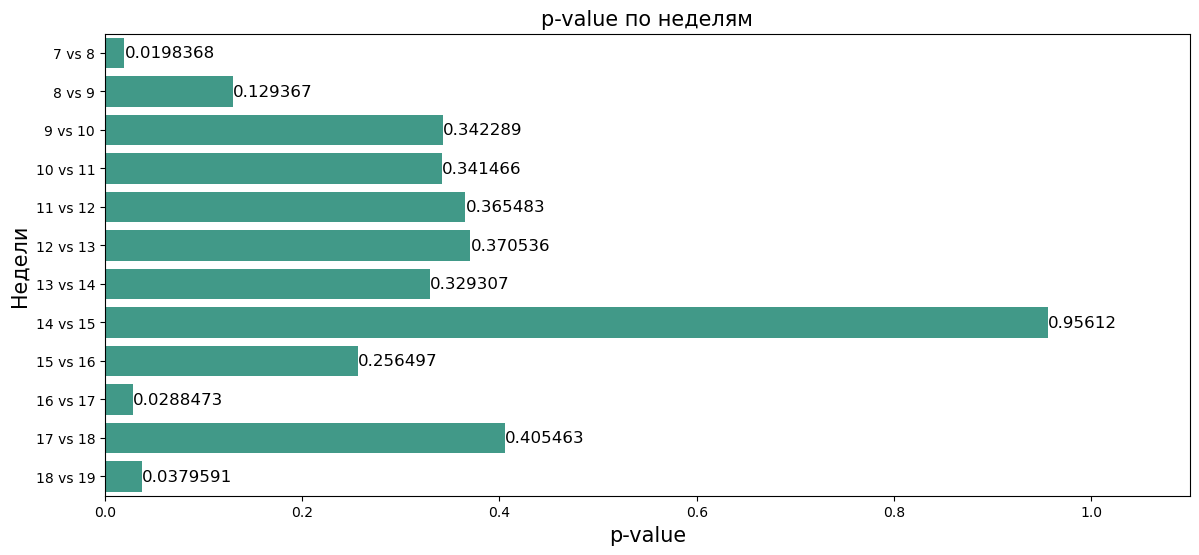

In [7]:
plt.figure(figsize=(14, 6))
plt.gca().set_xlim(0, 1.1)
ax = sns.barplot(results_df, y = 'Comparison', x = 'p_value', color = '#32a891')
ax.bar_label(ax.containers[0], fontsize=12)

plt.title('p-value по неделям', size=15)
plt.ylabel('Недели',size=15)
plt.xlabel('p-value',size=15);

**Вывод:**   
Анализ показал, что для: 7 и 8, 16 и 17, 18 и 19 недель значение **p-value ниже 0.05** (уровня значимости), следовательно **есть основания отвергнуть нулевую гипотезу о равенстве законов распределений.**   
Выборки в этих парах имеют статистически значимые различия.
  
**В остальных случаях p-value > 0.05**, следовательно **нет оснований отвергать гипотезу равенстве законов распределений** в этих парах.  
Выборки в этих парах не имеют статистически значимых различий

Построим гистограммы для 7 и 8 недель и для пары, показавшей самое большое значение p-value - 14 и 15 недель

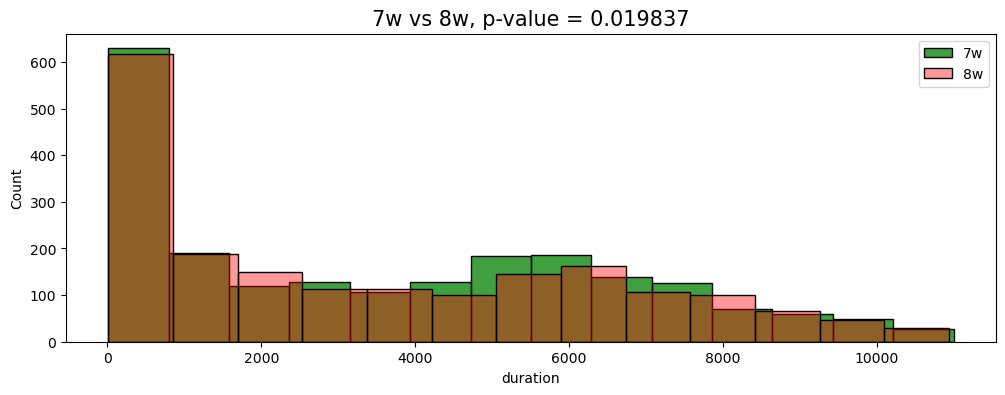

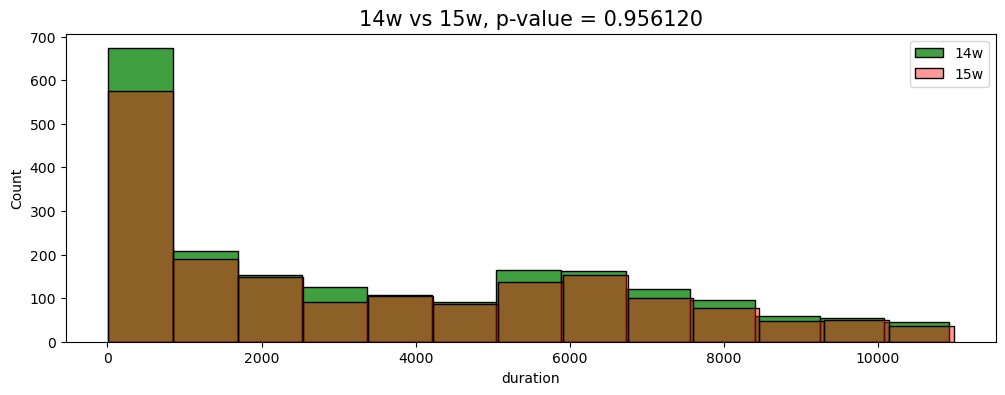

In [8]:
plt.figure(figsize=(12, 4))
sns.histplot(netflix_2018[netflix_2018['week'] == 7] ['duration'], color = 'g', label = '7w')
sns.histplot(netflix_2018[netflix_2018['week'] == 8] ['duration'], color = 'r', alpha = 0.4, label = '8w')
plt.title('7w vs 8w, p-value = 0.019837', size=15)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(netflix_2018[netflix_2018['week'] == 14] ['duration'], color = 'g', label = '14w')
sns.histplot(netflix_2018[netflix_2018['week'] == 15] ['duration'], color = 'r', alpha = 0.4, label = '15w')
plt.title('14w vs 15w, p-value = 0.956120', size=15)
plt.legend()
plt.show()

**Как видно, визуально по гистрограммам сложно точно определить разницу между законами распределения**

# 2. Дискретная метрика

В качестве дискретной метрики возьмем количество просмотренных фильмов в жанре комедии за одну неделю разными пользователями

In [9]:
# выберем все фильмы, в жанре которых относится к комедиям
netflix_2018_comedy = netflix_2018[netflix_2018['genres'].str.contains('Comedy')]
# отфильтруем нужные недели
netflix_2018_comedy[netflix_2018_comedy['week'].isin([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]
netflix_2018_comedy.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,week,year
247402,306175,2018-01-01 07:28:38,361.0,Monsters vs. Aliens,"Animation, Action, Adventure, Comedy, Family, ...",2009-03-27,7a590dd3d6,8d3b85115c,1,2018
247414,306187,2018-01-01 18:45:06,299.0,"Mum, Dad, Meet Sam","Comedy, Romance",2014-12-06,31e725af9f,73df0e721f,1,2018
247415,306188,2018-01-01 18:54:38,26.0,Carrie Pilby,"Comedy, Drama",2017-04-04,2a435ee6c4,b660e56acb,1,2018
247416,306189,2018-01-01 19:14:19,37.0,The Young Offenders,"Adventure, Comedy, Crime, Drama",2016-09-16,34b814c12e,755fa617f1,1,2018
247423,306196,2018-01-01 20:11:25,6600.0,Ted 2,Comedy,2015-06-26,ec7391f43a,c4a7dc6c48,1,2018


Рассчитаем **расстояние Кульбака-Лейблера** для пар недель, начиная с седьмой

In [10]:
weeks = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
kl_distances = []  # пустой список для хранения значений расстояний
comparisons = []

# подсчитаем равним расстояние Кульбака-Лейблера для пар недель
for i in range(1, len(weeks)):
    sam1 = netflix_2018_comedy[netflix_2018_comedy['week'] == weeks[i-1]] ['user_id']. \
    value_counts().reset_index(name='film_cnt')['film_cnt']
    
    sam2 = netflix_2018_comedy[netflix_2018_comedy['week'] == weeks[i]] ['user_id']. \
    value_counts().reset_index(name='film_cnt')['film_cnt']
    
    # т.к. для подсчета расстояния Кульбака-Лейблера размер выборок должен быть одинаковым
    # возьмем из каждого набора случайным образом одинаковое число значений 
    iddd = [len(sam1), len(sam2)]
    size = min(iddd)
    sam1 = np.random.choice(sam1, size)
    sam2 = np.random.choice(sam2, size)
    
    # выполним нормировку выборок
    sam1_normalized = sam1 / size
    sam2_normalized = sam2 / size
    
    # подсчет расстояния Кульбака-Лейблера
    kl_dist = entropy(sam1_normalized, sam2_normalized)
    kl_distances.append(kl_dist)  # Добавляем новое значение в список
    comparison = f"{weeks[i-1]} vs {weeks[i]}"
    comparisons.append(comparison)

# датафрейм с результатами
result_df = pd.DataFrame({'Comparison': comparisons, 'kl_distance': kl_distances})
result_df

,Comparison,kl_distance
0,7 vs 8,0.289353
1,8 vs 9,0.285230
2,9 vs 10,0.264833
3,10 vs 11,0.267508
4,11 vs 12,0.576077
5,12 vs 13,0.327284
6,13 vs 14,0.501883
7,14 vs 15,0.335812
8,15 vs 16,0.351823
9,16 vs 17,0.345371


Визуализируем результаты

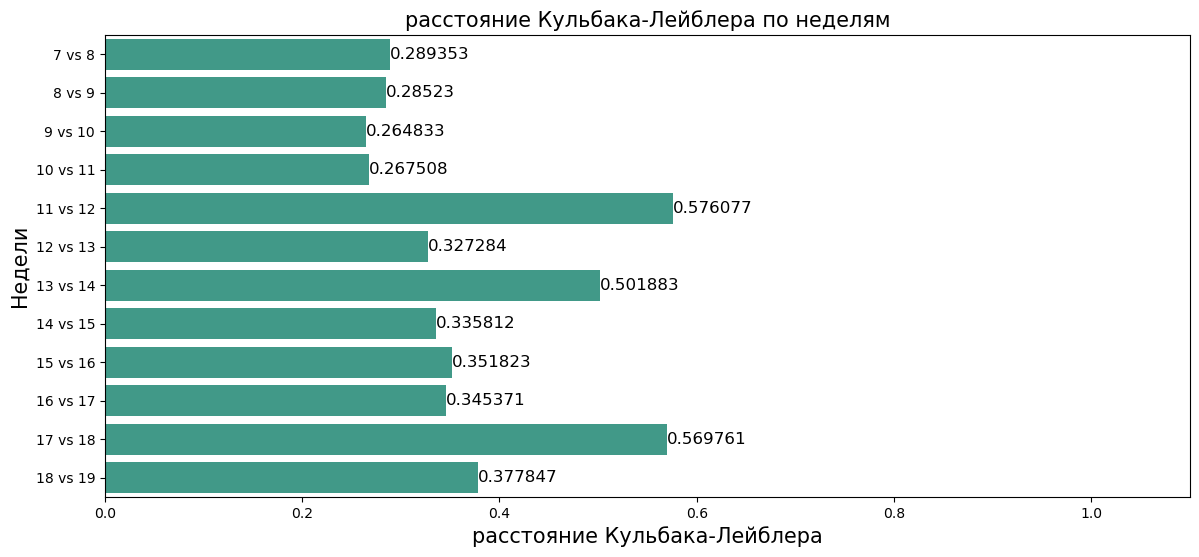

In [11]:
plt.figure(figsize=(14, 6))
plt.gca().set_xlim(0, 1.1)
ax = sns.barplot(result_df, y = 'Comparison', x = 'kl_distance', color = '#32a891')
ax.bar_label(ax.containers[0], fontsize=12)

plt.title('расстояние Кульбака-Лейблера по неделям', size=15)
plt.ylabel('Недели',size=15)
plt.xlabel('расстояние Кульбака-Лейблера',size=15);

**Выводы:** наибольшая дивергенция наблюдается между 11 и 12 неделей  
Энтропия нигде не выродилась в ноль, значит **между всеми парами есть различия**